# INM702: Task 1

This task is about classifying images of written numbers from the MNIST dataset. We develop a neural network using basic libraries such as NumPy, without resorting to ready-made functions from TensorFlow, Keras or PyTorch.

### Import Libraries and Load MNIST

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Ignore warnings (making the work easier to read)
import warnings
warnings.filterwarnings("ignore")

# Use TensorFlow to load MNIST (easy method)
import tensorflow.keras.datasets.mnist as mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [2]:
# Length * Width
image_pixels = X_train.shape[1] * X_train.shape[1]

# Convert training and test sets to 2-D arrays, and normalise
X_train = X_train.reshape((X_train.shape[0], image_pixels)).T / 255.0
X_test = X_test.reshape((X_test.shape[0], image_pixels)).T / 255.0

# One-hot encoder function
def one_hot_encoder(labels):
    num_classes = np.max(labels) + 1
    one_hot_labels = np.eye(num_classes)[labels]
    return one_hot_labels

y_train_one_hot = one_hot_encoder(y_train).T
y_test_one_hot = one_hot_encoder(y_test).T

X_train.shape, X_test.shape, y_train_one_hot.shape, y_test_one_hot.shape

((784, 60000), (784, 10000), (10, 60000), (10, 10000))

### Sigmoid, ReLU and Softmax Layers

In [3]:
# Sigmoid with derivative
def sigmoid(x):
    s = 1.0 / (1.0 + np.exp(-x))
    ds = s * (1.0 - s)
    return s, ds

# ReLU with derivative
def relu(x):
    return x * (x >= 0), (x > 0).astype(float)

# Softmax
def softmax(vec):
    return np.exp(vec) / np.exp(vec).sum()

Sigmoid/Derivative



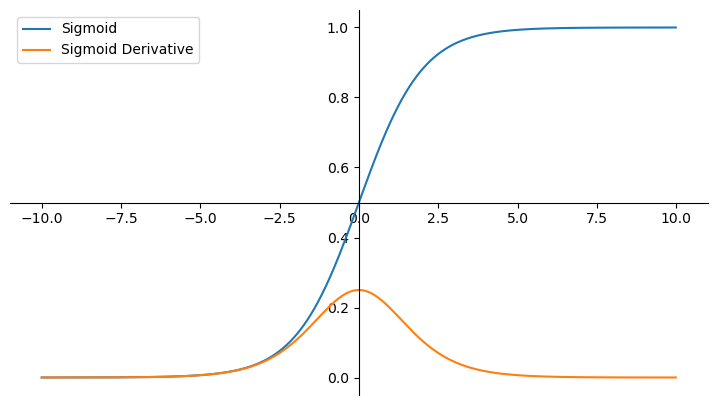

ReLU/Derivative


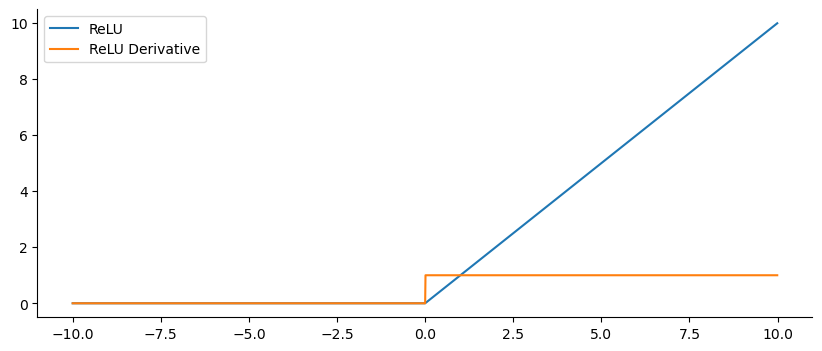

In [4]:
# Set range of input values for Sigmoid and ReLU
x = np.arange(-10, 10, 0.01)

# Generate Sigmoid/Derivative Plot
print("Sigmoid/Derivative\n")

fig1, ax1 = plt.subplots(figsize=(9, 5))

ax1.spines["left"].set_position("center")
ax1.spines["bottom"].set_position("center")
ax1.spines["top"].set_color("none")
ax1.spines["right"].set_color("none")

ax1.plot(x, sigmoid(x)[0], label = "Sigmoid")
ax1.plot(x, sigmoid(x)[1], label = "Sigmoid Derivative")
ax1.legend(loc = "upper left")
plt.show()

# Generate ReLU/Derivative Plot
print("ReLU/Derivative")

fig2, ax2 = plt.subplots(figsize = (10, 4))

ax2.spines["top"].set_color("none")
ax2.spines["right"].set_color("none")

ax2.plot(x, relu(x)[0], label = "ReLU")
ax2.plot(x, relu(x)[1], label = "ReLU Derivative")
ax2.legend(loc = "upper left")
plt.show()

### Set Random Seeds

In [5]:
# Random Seed and Seed Choice

randomer = 50
random.seed(randomer)
np.random.seed(randomer)

### Dropout Regularisation

In [ ]:
######

### Neural Network Class

In [6]:
# Neural Network Class

class NeuralNetwork:
    """
    Neural Network Class

    Parameters:
    - layer_sizes: A list containing first the input size, and lastly the output size. Hidden layers can optionally be added
      in between. For example [10, 128, 64, 2] for input of size 10, two hidden layers of size 128 and 64 respectively,
      and output of size 2.
    - activation_function: Activation function used in every layer.
    #- dropout_rate: ...
    - random_state: Seed used to generate the random weights. If no seed is specified, the seed set as 'randomer' will be used.
    """
    def __init__(self, layer_sizes, activation_function, random_state = randomer):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.activation_function = activation_function
        self.random_state = random_state
        self.parameters = self.initialise_parameters()

    # Initialise weights
    def initialise_parameters(self):
        # Use random seed defined in the class parameters
        np.random.seed(self.random_state)
        # Create dictionary to store the weights
        parameters = {}
        # Go over each layer and create random weights
        for l in range(1, self.num_layers):
            # Normal distribution with mean 0 and standard deviation 0.01
            parameters[f"W{l}"] = np.random.randn(self.layer_sizes[l], self.layer_sizes[l - 1]) * 0.01
            parameters[f"b{l}"] = np.zeros((self.layer_sizes[l], 1))
        return parameters
    
    # Forward propagation
    def forward_propagation(self, X):
        cache = {"A0": X}
        for l in range(1, self.num_layers):
            Wl, bl = self.parameters[f"W{l}"], self.parameters[f"b{l}"]
            Al_prev = cache[f"A{l - 1}"]
            
            Zl = np.dot(Wl, Al_prev) + bl
            Al = self.activation_function(Zl)[0]
            
            cache[f"Z{l}"] = Zl
            cache[f"A{l}"] = Al
        
        return Al, cache

    # Categorical cross-entropy loss function
    def compute_categorical_cross_entropy_loss(self, A, Y):
        m = Y.shape[1]
    
        # Clip probabilities to avoid log(0) issues
        epsilon = 1e-15
        A = np.clip(A, epsilon, 1 - epsilon)
    
        # Compute categorical cross-entropy loss
        loss = -np.sum(Y * np.log(A)) / m
    
        return loss
    
    # Backpropagation
    def backpropagation(self, A, Y, cache):
        m = Y.shape[1]
        gradients = {}

        dZ = A - Y
        for l in reversed(range(1, self.num_layers)):
            Al_prev = cache[f"A{l - 1}"]
            Wl = self.parameters[f"W{l}"]

            gradients[f"dW{l}"] = np.dot(dZ, Al_prev.T) / m
            gradients[f"db{l}"] = np.sum(dZ, axis = 1, keepdims = True) / m

            dZ = np.dot(Wl.T, dZ) * self.activation_function(Al_prev)[1]

        return gradients

    # Update weights
    def update_parameters(self, gradients, learning_rate):
        for l in range(1, self.num_layers):
            self.parameters[f"W{l}"] -= learning_rate * gradients[f"dW{l}"]
            self.parameters[f"b{l}"] -= learning_rate * gradients[f"db{l}"]
    
    # Function to train data, with epochs and learning rate as parameters
    def train(self, X, Y, num_epochs, learning_rate):
        # Save losses to list
        losses = []
        
        for epoch in range(num_epochs):
            # Forward propagation
            A, cache = self.forward_propagation(X)
            
            # Compute loss
            loss = self.compute_categorical_cross_entropy_loss(A, Y)

            # Backpropagation
            gradients = self.backpropagation(A, Y, cache)

            # Update parameters
            self.update_parameters(gradients, learning_rate)
            
            # Output epoch number and loss value
            print(f"Epoch {epoch}, Loss: {loss}")
            
            # Append loss value to list
            losses.append(loss)
        
        return losses
    
    # Function for making predictions
    def predict(self, X):
        # Predict using forward propagation
        predictions, _ = self.forward_propagation(X)
        return predictions
    
    # Function to generate a confusion matrix
    def confusion_matrix(self, true_labels, predicted_labels):
        # Identify number of classes
        num_classes = len(np.unique(true_labels))
        # Create matrix of zeroes of size num_classes*num_classes
        cm = np.zeros((num_classes, num_classes), dtype = int)
        
        # Fill in the confusion matrix appropriately
        for true, predicted in zip(true_labels, predicted_labels):
            cm[true, predicted] += 1

        return cm
    
    # Function to plot confusion matrix from 'confusion_matrix'
    def plot_confusion_matrix(self, cm, classes):
        plt.imshow(cm, interpolation = "nearest", cmap = plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")

        # Add text annotations for each cell in the confusion matrix
        for i in range(len(classes)):
            for j in range(len(classes)):
                plt.text(j, i, str(cm[i, j]), ha = "center", va = "center", color = "white" if cm[i, j] > cm.max() / 2 else "black")

        plt.show()
    
    # Generate and plot confusion matrix from 'confusion_matrix' and 'plot_confusion_matrix', using the model
    def evaluate_confusion_matrix(self, X, Y, classes):
        # Make predictions of test set (or otherwise) using the model
        predictions = self.predict(X)
        # Define the predicted labels
        predicted_labels = np.argmax(predictions, axis = 0)
        # Define the true labels
        true_labels = np.argmax(Y, axis = 0)
        
        # Create and plot confusion matrix
        cm = self.confusion_matrix(true_labels, predicted_labels)
        self.plot_confusion_matrix(cm, classes = classes)

        return cm

### Hyperparameters

In [7]:
num_epochs = 300
learning_rate = 0.1

### Train Neural Network

In [8]:
# Define layer sizes (input, hidden, output)

input_size = X_train.shape[0]
output_size = y_train_one_hot.shape[0]
layer_sizes = [input_size, 64, output_size]

# Define model and train neural network on training set

model = NeuralNetwork(layer_sizes = layer_sizes, activation_function = relu, random_state = randomer)
history = model.train(X_train, y_train_one_hot, num_epochs = num_epochs, learning_rate = learning_rate)

Epoch 0, Loss: 13.671582516634384
Epoch 1, Loss: 4.252591875607866
Epoch 2, Loss: 3.632204282021942
Epoch 3, Loss: 3.293499609600848
Epoch 4, Loss: 3.0592987728712537
Epoch 5, Loss: 2.8834697797450217
Epoch 6, Loss: 2.745595016610771
Epoch 7, Loss: 2.6348625154416165
Epoch 8, Loss: 2.5447310165411463
Epoch 9, Loss: 2.470806867085593
Epoch 10, Loss: 2.40985162374028
Epoch 11, Loss: 2.3593219547998348
Epoch 12, Loss: 2.317137138615007
Epoch 13, Loss: 2.281573048686059
Epoch 14, Loss: 2.251177403279739
Epoch 15, Loss: 2.224743533194933
Epoch 16, Loss: 2.2012996918807834
Epoch 17, Loss: 2.180063041574375
Epoch 18, Loss: 2.1604018106284704
Epoch 19, Loss: 2.141823010652598
Epoch 20, Loss: 2.123935498950074
Epoch 21, Loss: 2.106439304513471
Epoch 22, Loss: 2.0891119554438067
Epoch 23, Loss: 2.071768918536734
Epoch 24, Loss: 2.054286431866064
Epoch 25, Loss: 2.036559147080221
Epoch 26, Loss: 2.0185336175017756
Epoch 27, Loss: 2.0001609405362957
Epoch 28, Loss: 1.981401448524908
Epoch 29, Loss

Epoch 233, Loss: 1.1891612293483935
Epoch 234, Loss: 1.1881649178926816
Epoch 235, Loss: 1.1876367948077038
Epoch 236, Loss: 1.1870465857754942
Epoch 237, Loss: 1.187024401960701
Epoch 238, Loss: 1.1883237155063027
Epoch 239, Loss: 1.1881212709492932
Epoch 240, Loss: 1.1871119841067108
Epoch 241, Loss: 1.1853216893608456
Epoch 242, Loss: 1.1851738071433051
Epoch 243, Loss: 1.1851122602923474
Epoch 244, Loss: 1.1837803130195552
Epoch 245, Loss: 1.1829434721407919
Epoch 246, Loss: 1.183786116841501
Epoch 247, Loss: 1.1841386478957323
Epoch 248, Loss: 1.1840219368447706
Epoch 249, Loss: 1.1830871693189347
Epoch 250, Loss: 1.1829800362776208
Epoch 251, Loss: 1.1811830190931938
Epoch 252, Loss: 1.1785128124632815
Epoch 253, Loss: 1.1779852398114325
Epoch 254, Loss: 1.1771358257403444
Epoch 255, Loss: 1.1767275069516778
Epoch 256, Loss: 1.1771777509778738
Epoch 257, Loss: 1.1763898223063263
Epoch 258, Loss: 1.177718848504742
Epoch 259, Loss: 1.176865807091154
Epoch 260, Loss: 1.1764080091586

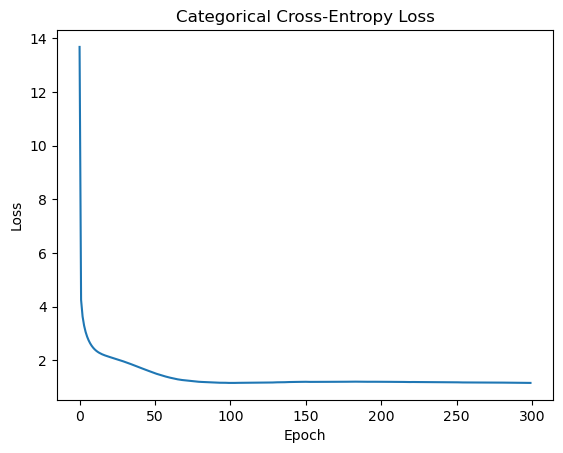

In [9]:
# Display loss per epoch

plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Categorical Cross-Entropy Loss")
plt.show()

### Test Neural Network (Metrics)

In [10]:
# Test the neural network
predictions = model.predict(X_test)

# Evaluate accuracy
accuracy = np.mean(np.argmax(predictions, axis = 0) == np.argmax(y_test_one_hot, axis = 0))

print(f"Accuracy: {round(accuracy, 4) * 100}%")

Accuracy: 89.85%


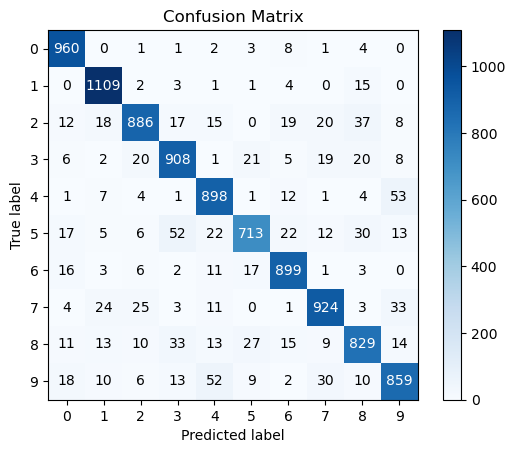

array([[ 960,    0,    1,    1,    2,    3,    8,    1,    4,    0],
       [   0, 1109,    2,    3,    1,    1,    4,    0,   15,    0],
       [  12,   18,  886,   17,   15,    0,   19,   20,   37,    8],
       [   6,    2,   20,  908,    1,   21,    5,   19,   20,    8],
       [   1,    7,    4,    1,  898,    1,   12,    1,    4,   53],
       [  17,    5,    6,   52,   22,  713,   22,   12,   30,   13],
       [  16,    3,    6,    2,   11,   17,  899,    1,    3,    0],
       [   4,   24,   25,    3,   11,    0,    1,  924,    3,   33],
       [  11,   13,   10,   33,   13,   27,   15,    9,  829,   14],
       [  18,   10,    6,   13,   52,    9,    2,   30,   10,  859]])

In [11]:
# Output confusion matrix

# 10 classes (as there are 10 digits)
class_names = [str(i) for i in range(10)]

# Call model and output confusion matrix
model.evaluate_confusion_matrix(X_test, y_test_one_hot, classes = class_names)